In [1]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

from srai.embedders import GTFS2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders import GTFSLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods.h3_neighbourhood import H3Neighbourhood
from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.plotting import plot_regions, plot_numeric_data

In [2]:
if torch.cuda.is_available():
    num_workers=4
    pin_memory=True
    accelerator="cuda"
else:
    num_workers=0
    pin_memory=False
    accelerator="cpu"

logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

cleaned_sources = pd.read_csv(Path('..', 'data', 'cleaned_sources.csv'))

In [3]:
# Test model on each city
res = {}
test_sources = cleaned_sources.iloc[:]
for i, row in test_sources.iterrows():
    model = model_utils.load_model("../logs/saved_models/", "kcm_1month_resampled", "GRU", 0)
    model.eval()
    test_dates = ['2024_01_03.pkl']
    train_data_folders = [Path('..', 'data', 'other_feeds', f"{row['uuid']}_realtime", 'processed')]
    available_files = [x.name for x in Path('..', 'data', 'other_feeds', f"{row['uuid']}_realtime", 'processed').glob('*.pkl')]
    if test_dates[0] not in available_files:
        continue
    print(row['provider'])
    test_data, holdout_routes, test_config = data_loader.load_h5(train_data_folders, test_dates, holdout_routes=model.holdout_routes, config=model.config)
    test_dataset = data_loader.H5Dataset(test_data)
    test_dataset.include_grid = model.include_grid
    test_loader = DataLoader(
        test_dataset,
        collate_fn=model.collate_fn,
        batch_size=model.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    trainer = pl.Trainer(
        accelerator=accelerator,
        logger=False,
        inference_mode=True,
        enable_progress_bar=False
    )
    preds_and_labels = trainer.predict(model=model, dataloaders=test_loader)
    preds = np.concatenate([x['preds'] for x in preds_and_labels])
    labels = np.concatenate([x['labels'] for x in preds_and_labels])
    res[row['uuid']] = {'preds':preds, 'labels':labels}

London Transit Commission
Barrie Transit
Big Blue Bus
Mountain View Transportation Management Association (MVgo)
Capital Metro
Regional Transportation District (RTD)
Metro St. Louis
Intercity Transit
Duluth Transit
Central Florida Regional Transit Authority (LYNX)
Votran
Nashville Metropolitan Transit Authority (Nashville MTA)
Transit Authority of River City (TARC)
Metropolitan Atlanta Rapid Transit Authority (MARTA)
Springfield Mass Transit District (SMTD)
Metro Transit
Port Authority of Allegheny County
Massachusetts Bay Transportation Authority (MBTA)
Arlington Transit
Rochester-Genesee Regional Transportation Authority (RGRTA)
BC Transit (Victoria Regional Transit System)
Edmonton Transit System
Saskatoon Transit
Hamilton Street Railway
MiWay
Kingston Transit
Halifax Transit
Thunder Bay Transit
Port Alberni
Commerce Municipal Bus Lines
King County Metro
Stanislaus Regional Transit Authority (StanRTA)


In [41]:
# Tune, then re-test
res_tuned = {}
test_sources = cleaned_sources.iloc[:]
for i, row in test_sources.iterrows():
    test_dates = ['2024_01_03.pkl']
    train_data_folders = [Path('..', 'data', 'other_feeds', f"{row['uuid']}_realtime", 'processed')]
    available_files = [x.name for x in Path('..', 'data', 'other_feeds', f"{row['uuid']}_realtime", 'processed').glob('*.pkl')]
    if test_dates[0] not in available_files:
        continue
    print(row['provider'])
    res_tuned[row['uuid']] = {}
    for n_batches in [1, 2, 4]:
        model = model_utils.load_model("../logs/saved_models/", "kcm_1month_resampled", "GRU", 0)
        model.eval()
        test_data, holdout_routes, test_config = data_loader.load_h5(train_data_folders, test_dates, holdout_routes=model.holdout_routes, config=model.config)
        test_dataset = data_loader.H5Dataset(test_data)
        test_dataset.include_grid = model.include_grid
        test_loader = DataLoader(
            test_dataset,
            collate_fn=model.collate_fn,
            batch_size=model.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        trainer = pl.Trainer(
            accelerator=accelerator,
            logger=False,
            inference_mode=True,
            enable_progress_bar=False,
            enable_model_summary=False,
            max_epochs=10,
            limit_train_batches=n_batches
        )
        trainer.fit(model=model, train_dataloaders=test_loader)
        preds_and_labels = trainer.predict(model=model, dataloaders=test_loader)
        preds = np.concatenate([x['preds'] for x in preds_and_labels])
        labels = np.concatenate([x['labels'] for x in preds_and_labels])
        res_tuned[row['uuid']][f"{n_batches}_batches"] = {'preds':preds, 'labels':labels}

London Transit Commission


/home/zack/Desktop/open_bus_tools/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/zack/Desktop/open_bus_tools/.venv/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/zack/Desktop/open_bus_tools/notebooks/checkpoints exists and is not empty.


Barrie Transit
Big Blue Bus
Mountain View Transportation Management Association (MVgo)
Capital Metro
Regional Transportation District (RTD)
Metro St. Louis
Intercity Transit
Duluth Transit
Central Florida Regional Transit Authority (LYNX)
Votran
Nashville Metropolitan Transit Authority (Nashville MTA)
Transit Authority of River City (TARC)
Metropolitan Atlanta Rapid Transit Authority (MARTA)
Springfield Mass Transit District (SMTD)
Metro Transit
Port Authority of Allegheny County
Massachusetts Bay Transportation Authority (MBTA)
Arlington Transit
Rochester-Genesee Regional Transportation Authority (RGRTA)
BC Transit (Victoria Regional Transit System)
Edmonton Transit System
Saskatoon Transit
Hamilton Street Railway
MiWay
Kingston Transit
Halifax Transit
Thunder Bay Transit
Port Alberni
Commerce Municipal Bus Lines
King County Metro
Stanislaus Regional Transit Authority (StanRTA)


In [45]:
metrics = {}
for key, value in res.items():
    metrics[key] = model_utils.performance_metrics(value['labels'], value['preds'])
metrics_df = pd.DataFrame(metrics).T
metrics_df.index.name = 'uuid'
metrics_df = metrics_df.reset_index()
metrics_df = pd.merge(metrics_df, cleaned_sources, on='uuid')
metrics_df['experiment'] = 'not-tuned'
metrics_df['n_batches'] = '0_batches'
metrics_df[['provider','n_batches','experiment','mae', 'mape', 'rmse', 'ex_var', 'r_score']].sort_values(['provider', 'n_batches']).head(10)

,provider,n_batches,experiment,mae,mape,rmse,ex_var,r_score
18,Arlington Transit,0_batches,not-tuned,69.569825,0.224919,8.340853,0.775192,0.771584
20,BC Transit (Victoria Regional Transit System),0_batches,not-tuned,111.589098,0.259579,10.563574,0.777157,0.728569
1,Barrie Transit,0_batches,not-tuned,116.481377,0.237706,10.792654,0.793000,0.792672
2,Big Blue Bus,0_batches,not-tuned,346.089513,0.434805,18.603481,0.686116,0.263355
4,Capital Metro,0_batches,not-tuned,215.147161,0.263385,14.667896,0.743784,0.720664
9,Central Florida Regional Transit Authority (LYNX),0_batches,not-tuned,161.216318,0.260830,12.697099,0.550255,0.526094
29,Commerce Municipal Bus Lines,0_batches,not-tuned,205.992501,0.269350,14.352439,0.683146,0.656156
8,Duluth Transit,0_batches,not-tuned,126.026914,0.285953,11.226171,0.785196,0.784499
21,Edmonton Transit System,0_batches,not-tuned,115.017353,0.258047,10.724614,0.777081,0.776323
26,Halifax Transit,0_batches,not-tuned,129.650576,0.325215,11.386421,0.680104,0.676025


In [46]:
metrics = {}
for k_uuid, res_uuid in res_tuned.items():
    for k_n_batches, res_n_batches in res_uuid.items():
        metrics[(k_uuid, k_n_batches)] = model_utils.performance_metrics(res_n_batches['labels'], res_n_batches['preds'])
metrics_tuned_df = pd.DataFrame(metrics).T
metrics_tuned_df.index.names = ['uuid', 'n_batches']
metrics_tuned_df = metrics_tuned_df.reset_index()
metrics_tuned_df = pd.merge(metrics_tuned_df, cleaned_sources, on='uuid')
metrics_tuned_df['experiment'] = 'tuned'
metrics_tuned_df[['provider','n_batches','experiment','mae', 'mape', 'rmse', 'ex_var', 'r_score']].sort_values(['provider', 'n_batches']).head(10)

,provider,n_batches,experiment,mae,mape,rmse,ex_var,r_score
151,Arlington Transit,128_batches,tuned,46.755706,0.179666,6.837814,0.886084,0.882567
148,Arlington Transit,16_batches,tuned,47.968289,0.182138,6.925914,0.886586,0.878768
144,Arlington Transit,1_batches,tuned,47.231036,0.179317,6.872484,0.885291,0.880821
145,Arlington Transit,2_batches,tuned,47.063368,0.175729,6.860275,0.888068,0.881468
149,Arlington Transit,32_batches,tuned,47.408175,0.180911,6.885359,0.887721,0.879983
146,Arlington Transit,4_batches,tuned,47.043689,0.178609,6.858840,0.887190,0.882800
150,Arlington Transit,64_batches,tuned,47.366756,0.177036,6.882351,0.886998,0.879714
147,Arlington Transit,8_batches,tuned,47.008838,0.176873,6.856299,0.888629,0.881684
167,BC Transit (Victoria Regional Transit System),128_batches,tuned,58.076670,0.151077,7.620805,0.928405,0.927545
164,BC Transit (Victoria Regional Transit System),16_batches,tuned,59.399674,0.152677,7.707118,0.925121,0.922669


In [65]:
plot_df.groupby('n_batches')[['mape']].std()

,mape
n_batches,
0_batches,0.110069
1_batches,0.070764
2_batches,0.060201
4_batches,0.052487


<Axes: xlabel='MAPE', ylabel='Count'>

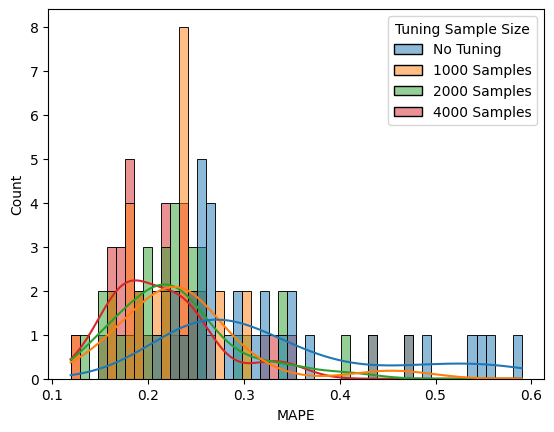

In [57]:
plot_df = pd.concat([metrics_df, metrics_tuned_df], axis=0)
plot_df = plot_df[plot_df['n_batches'].isin(['0_batches', '1_batches', '2_batches', '4_batches'])]
plot_df['Tuning Sample Size'] = plot_df['n_batches'].replace({'0_batches': 'No Tuning', '1_batches': '1000 Samples', '2_batches': '2000 Samples', '4_batches': '4000 Samples'})
plot_df['MAPE'] = plot_df['mape']
sns.histplot(plot_df, x='MAPE', hue='Tuning Sample Size', bins=50, kde=True)

In [ ]:
# loader = GTFSLoader()
# regionalizer = H3Regionalizer(resolution=11)
# joiner = IntersectionJoiner()

# area = geocode_to_region_gdf("Seattle")
# gtfs_file = Path("seattle_gtfs.zip")
# # download_file("https://metro.kingcounty.gov/GTFS/google_transit.zip", gtfs_file.as_posix())

# features = loader.load(gtfs_file)
# # Need to name index to match, and fill stops with NAs
# features.index = pd.Index(name="stop_id", data=features.index)
# for colname in features.columns:
#     if colname.startswith("directions_at_"):
#         for row in features.loc[features[colname].isnull(), colname].index:
#             features.at[row, colname] = set()


# regions = regionalizer.transform(area)

# joint = joiner.transform(regions, features)
# joint.index = pd.MultiIndex.from_tuples(joint.index, names=["region_id", "stop_id"])

# embedder = GTFS2VecEmbedder()
# neighbourhood = H3Neighbourhood(regions_gdf=regions)

In [ ]:
# embedder.fit(regions, features, joint)
# embeddings = embedder.transform(regions, features, joint)

In [ ]:
# folium_map = plot_regions(area, colormap=["rgba(0,0,0,0.1)"], tiles_style="CartoDB positron")
# plot_numeric_data(regions, 0, embeddings, map=folium_map)